# 🎨 Image Generation with GANs on CIFAR-10 using PyTorch
This notebook implements a Generative Adversarial Network (GAN) in PyTorch to synthesize realistic color images resembling those in the CIFAR-10 dataset. The project follows a complete deep learning workflow: loading and normalizing image data, visual exploratory data analysis (EDA), designing generator and discriminator networks, adversarial training with synchronized optimization, and qualitative evaluation through progressive visualization of generated samples.

In [1]:
# Cell 1: Import libraries and set global configurations
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [2]:
# Cell 2: Data loading and preprocessing
# CIFAR-10 images are 32x32 RGB; normalize to [-1, 1] for GAN stability
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # maps [0,1] → [-1,1]
])

train_dataset = datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

# Store class names for EDA
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

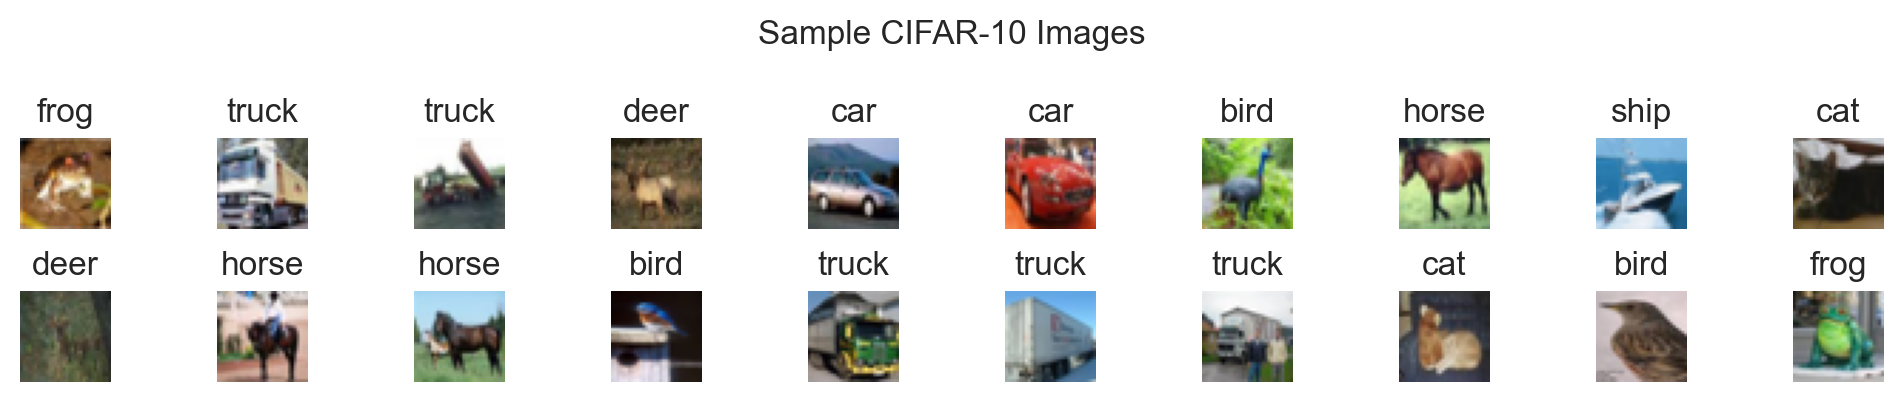

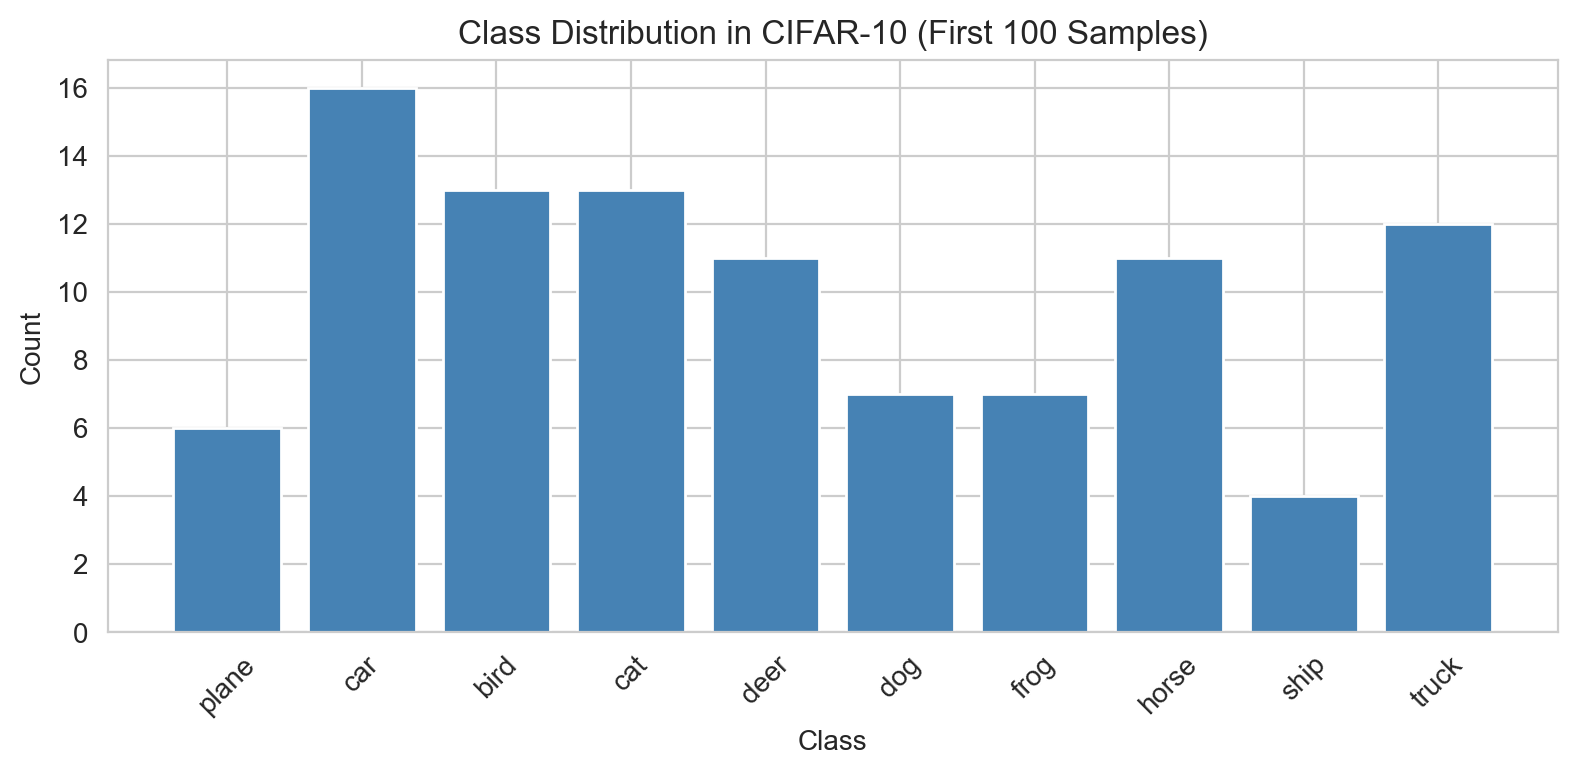

In [9]:
# Cell 3: Exploratory Data Analysis (EDA)
# Load raw (unnormalized) images for visualization
raw_dataset = datasets.CIFAR10(root='../../data', train=True, download=True)
raw_images = np.array([np.array(raw_dataset[i][0]) for i in range(100)])
raw_labels = np.array([raw_dataset[i][1] for i in range(100)])

# Display 20 random images
fig, axes = plt.subplots(2, 10, figsize=(10, 2))  # Only use figsize here for layout control; safe
for idx, ax in enumerate(axes.flat):
    img = raw_images[idx]
    label = classes[raw_labels[idx]]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.suptitle('Sample CIFAR-10 Images')
plt.tight_layout()
plt.show()

# Class distribution
plt.figure(figsize=(8, 4))
unique, counts = np.unique(raw_labels, return_counts=True)
plt.bar([classes[i] for i in unique], counts, color='steelblue')
plt.title('Class Distribution in CIFAR-10 (First 100 Samples)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Cell 4: Define Generator and Discriminator (DCGAN-style)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 16 x 16
            nn.ConvTranspose2d(128, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
latent_dim = 100
netG = Generator(latent_dim=latent_dim).to(device)
netD = Discriminator().to(device)

# Weight initialization (DCGAN recommendation)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [12]:
# Cell 5: Model training (GAN adversarial training loop)
# Hyperparameters
num_epochs = 10
learning_rate = 0.0001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Tracking losses
G_losses = []
D_losses = []

# Fixed noise for consistent visualization during training
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

print("Starting GAN training...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        label_real = torch.ones(batch_size, 1, device=device)
        label_fake = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        netD.zero_grad()
        # Real batch
        output_real = netD(real_images)
        lossD_real = criterion(output_real, label_real)
        # Fake batch
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, label_fake)
        # Total loss and update
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # -----------------
        # Train Generator
        # -----------------
        netG.zero_grad()
        output_fake = netD(fake_images)
        lossG = criterion(output_fake, label_real)  # Generator wants to fool D
        lossG.backward()
        optimizerG.step()

        # Save losses
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        if i % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], '
                  f'D_loss: {lossD.item():.4f}, G_loss: {lossG.item():.4f}')

print("Training completed.")

Starting GAN training...
Epoch [1/10], Step [0/391], D_loss: 1.3805, G_loss: 1.3804
Epoch [1/10], Step [200/391], D_loss: 0.2557, G_loss: 4.2168
Epoch [2/10], Step [0/391], D_loss: 0.6664, G_loss: 3.0740
Epoch [2/10], Step [200/391], D_loss: 0.7376, G_loss: 2.3933
Epoch [3/10], Step [0/391], D_loss: 0.6034, G_loss: 2.9615
Epoch [3/10], Step [200/391], D_loss: 0.3909, G_loss: 3.4225
Epoch [4/10], Step [0/391], D_loss: 0.8171, G_loss: 4.7948
Epoch [4/10], Step [200/391], D_loss: 0.4083, G_loss: 3.4432
Epoch [5/10], Step [0/391], D_loss: 0.5205, G_loss: 2.9112
Epoch [5/10], Step [200/391], D_loss: 0.4436, G_loss: 2.5568
Epoch [6/10], Step [0/391], D_loss: 0.3939, G_loss: 2.4243
Epoch [6/10], Step [200/391], D_loss: 0.2950, G_loss: 2.8417
Epoch [7/10], Step [0/391], D_loss: 0.3178, G_loss: 3.5029
Epoch [7/10], Step [200/391], D_loss: 0.3373, G_loss: 2.6465
Epoch [8/10], Step [0/391], D_loss: 0.6299, G_loss: 3.5323
Epoch [8/10], Step [200/391], D_loss: 0.5169, G_loss: 2.3610
Epoch [9/10], S

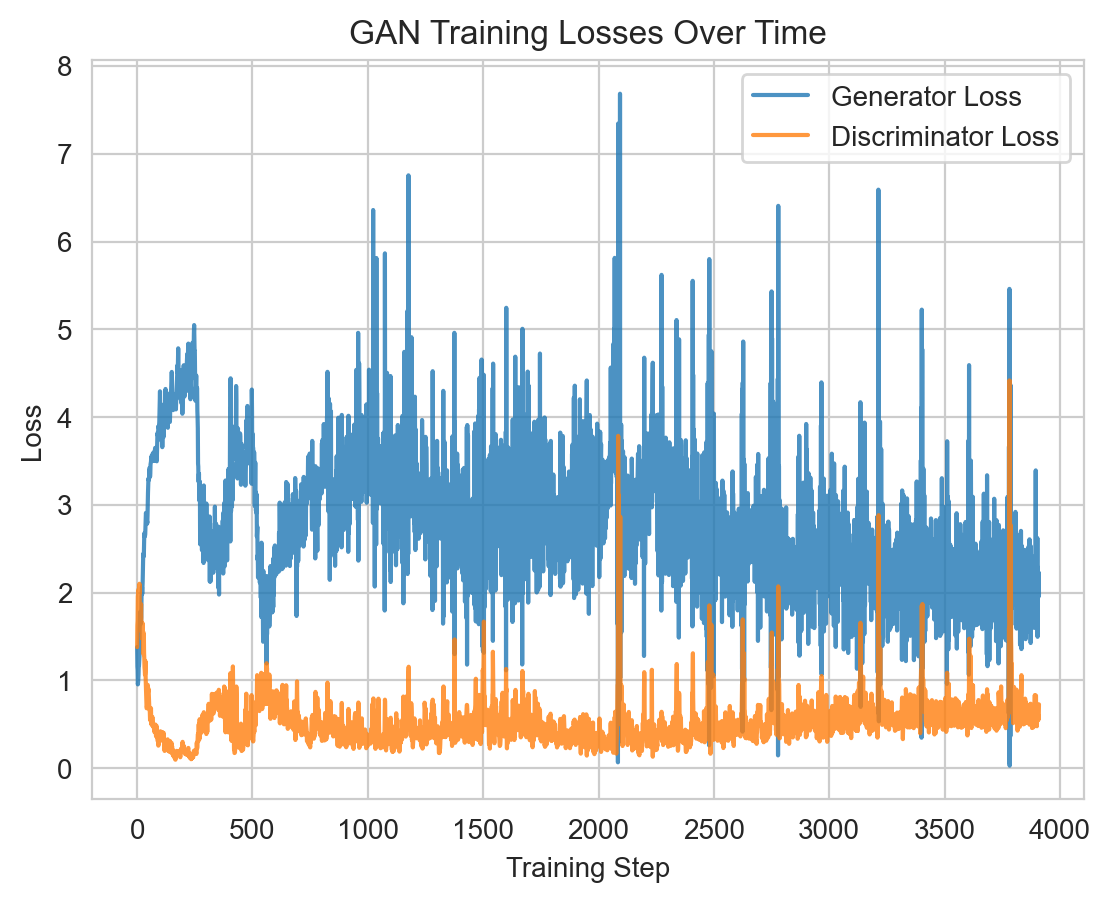

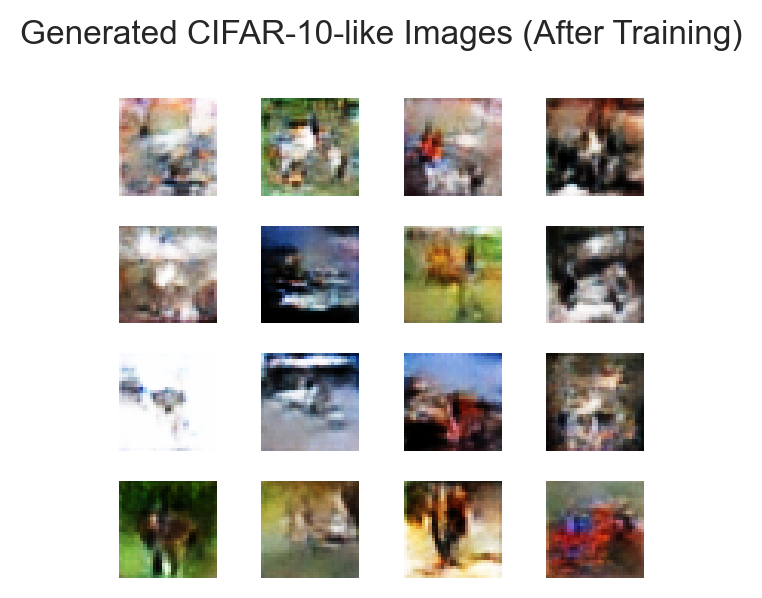

In [17]:
# Cell 6: Visualization of training progress and generated images
# Plot training losses
plt.plot(G_losses, label='Generator Loss', alpha=0.8)
plt.plot(D_losses, label='Discriminator Loss', alpha=0.8)
plt.title('GAN Training Losses Over Time')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate final images using fixed noise
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()

# Denormalize from [-1,1] → [0,1] for display
fake = (fake + 1) / 2.0

# Display generated images
fig, axes = plt.subplots(4, 4, figsize=(3, 3))
for i, ax in enumerate(axes.flat):
    img = fake[i].permute(1, 2, 0).numpy()
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
plt.suptitle('Generated CIFAR-10-like Images (After Training)')
plt.tight_layout()
plt.show()

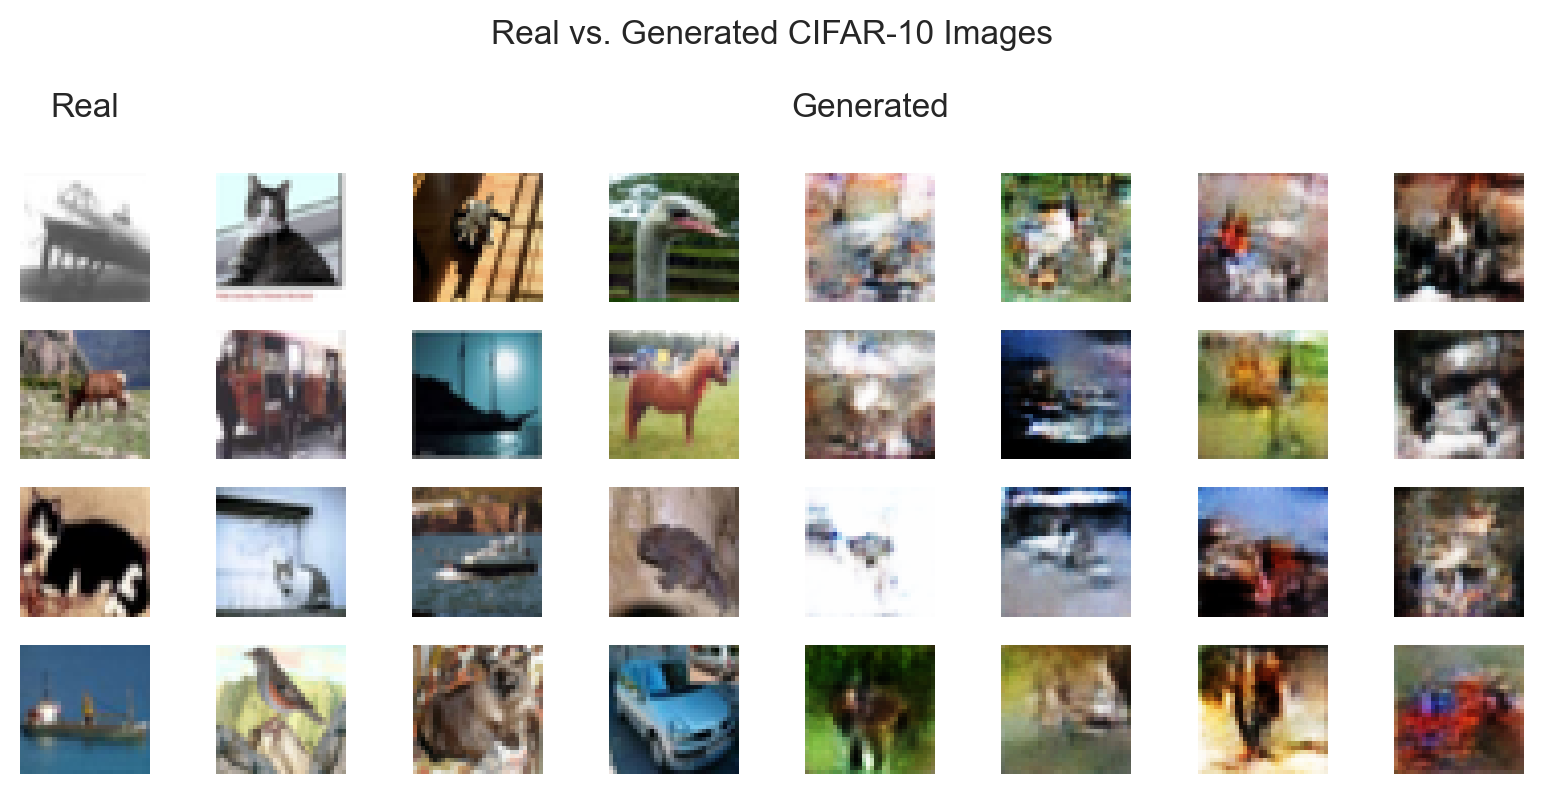

In [18]:
# Cell 7: Qualitative evaluation — compare real vs. fake
# Get a batch of real images
real_batch = next(iter(train_loader))[0][:16]
real_batch = (real_batch + 1) / 2.0  # Denormalize

# Plot side-by-side: real vs generated
fig, axes = plt.subplots(4, 8, figsize=(8, 4))
for i in range(4):
    for j in range(4):
        # Real images on left
        ax_real = axes[i, j]
        img_real = real_batch[i*4 + j].permute(1, 2, 0).numpy()
        ax_real.imshow(np.clip(img_real, 0, 1))
        ax_real.axis('off')
        if i == 0 and j == 0:
            ax_real.set_title('Real', fontsize=12, pad=20)
        # Fake images on right
        ax_fake = axes[i, j + 4]
        img_fake = fake[i*4 + j].permute(1, 2, 0).numpy()
        ax_fake.imshow(np.clip(img_fake, 0, 1))
        ax_fake.axis('off')
        if i == 0 and j == 0:
            ax_fake.set_title('Generated', fontsize=12, pad=20)
plt.suptitle('Real vs. Generated CIFAR-10 Images')
plt.tight_layout()
plt.show()